### Importing Dependencies

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers  #for model building
from tensorflow.keras import models
from IPython import display

#setting seed for experimentation reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

### Importing Dataset

Dataset: mini Speech Command dataset, smaller version for Speech Command Dataset which has 105,000 .wav format audio files and 35 corresponding words

In [2]:
import pathlib

DATASET_PATH = 'data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

182082353/182082353 [==============================] - 1s 0us/step


#### Dataset Exploration and preprocessing

In [47]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.

label names: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


In [48]:
for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)  #(64, 160000, 1) #since dataset has only single channel we can squeeze the extra  axiz
  print(example_labels.shape)  #once we squeeze we can play the audio file (1-D oe 2-D input required)


(64, 16000, 1)
(64,)


In [49]:
#dropping the extra axis
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

#### Audio clip shape
Audio clips of 1 second each sampled at 16 kHz or 16000 samples/sec:

* 1 sec of audio clip = 16000 samples(input)
* batch size = 64, example_audio.shape = (64, 16000)

In [50]:
for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)  #64 audio clip (batch size)
  print(example_labels.shape)  #64 coressponding labels

(64, 16000)
(64,)


In [9]:
example_labels

<tf.Tensor: shape=(64,), dtype=int32, numpy=
array([3, 6, 7, 6, 1, 2, 4, 6, 5, 3, 7, 5, 5, 4, 5, 1, 0, 5, 2, 3, 0, 4,
       7, 6, 3, 3, 7, 5, 2, 3, 3, 6, 5, 6, 3, 0, 0, 0, 0, 1, 6, 2, 7, 3,
       1, 2, 5, 4, 2, 0, 5, 4, 1, 5, 6, 4, 5, 1, 2, 7, 5, 6, 6, 2],
      dtype=int32)>

In [51]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: no
Waveform shape: (16000,)
Audio playback


Label: up
Waveform shape: (16000,)
Audio playback


Label: yes
Waveform shape: (16000,)
Audio playback


#### Plotting Audio Samples

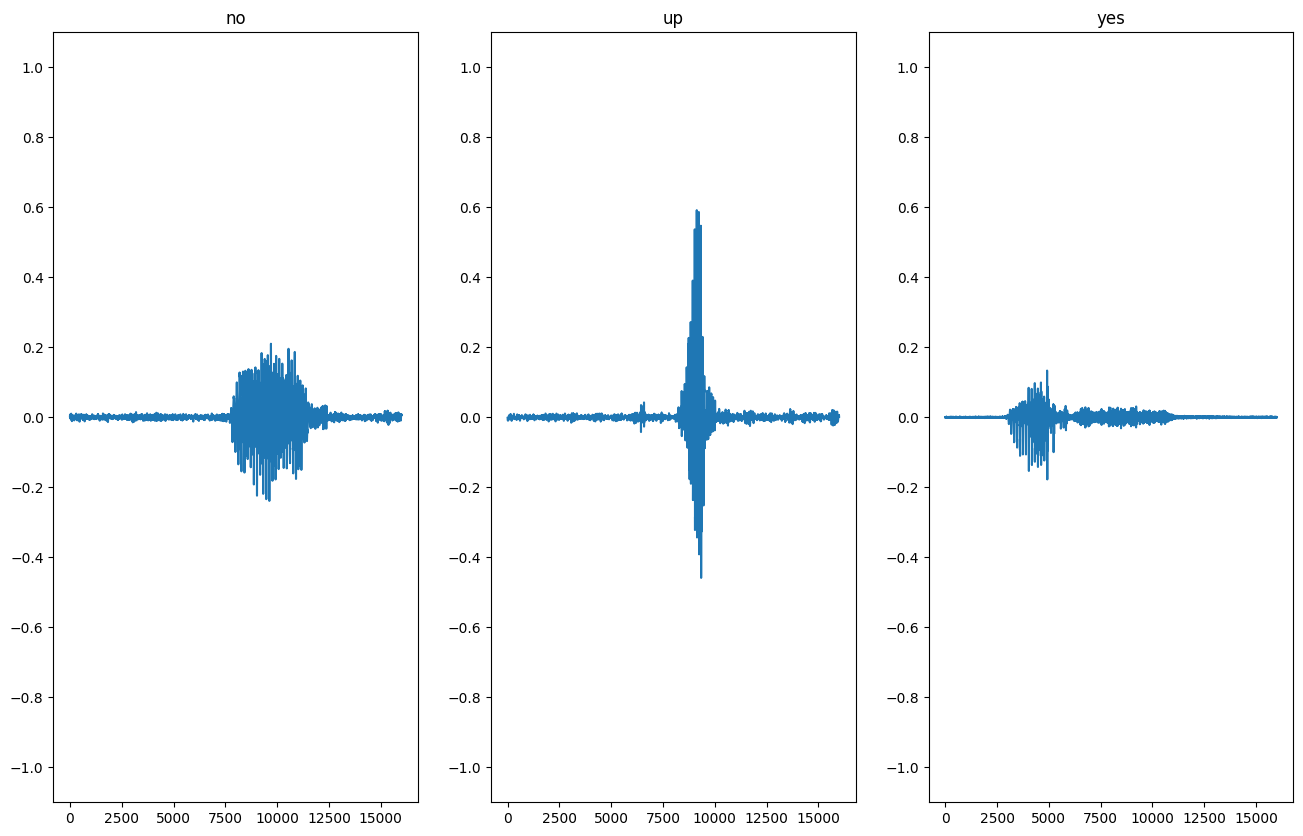

In [17]:
#audio sample representation in time domain
# horizontal axis - time
# vertical axis  - measurement of minuscule changes in air pressure
plt.figure(figsize=(16, 10))
rows = 1
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

#### Visulaizing Spectrogram

* Converting time domain audio signal to its corresponding frequency domain representation
* Horizontal axiz is time and vertical axis is the frquency of the signal.
* Fourier transform (tf.signal.fft) converts a signal to its component frequencies, but loses all time information. In comparison, STFT (tf.signal.stft) splits the signal into windows of time and runs a Fourier transform on each window

In [13]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [19]:
spectrogram = get_spectrogram(example_audio[0])
spectrogram.shape
# we need to remove the extra dim from spectrogram to visualize it using np.squeeze

TensorShape([124, 129, 1])

#### Plotting spectrogram
log_spec:
  * Convert the frequencies to log scale and transpose, so that the time is represented on the x-axis (columns).
  * Add an epsilon to avoid taking a log of zero.

In [37]:
def log_spectrogram(spectrogram):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)

  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  return log_spec

In [ ]:
#plotting spectrogram from log_spec
# height = log_spec.shape[0]
# width = log_spec.shape[1]
# X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
# Y = range(height)
# plt.pcolormesh(X, Y, log_spec)

#### Plotting Spectrogram

In [40]:
def plot_spec(i):
  fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (10,10))

  audio_signal = example_audio[i]
  label = example_labels[i]

  spectrogram = get_spectrogram(audio_signal)
  log_spec = log_spectrogram(spectrogram)

  for i in range(2):
    if i%2 !=0:
      #plotting spectrogram
      height = log_spec.shape[0]
      width = log_spec.shape[1]
      X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
      Y = range(height)
      ax[i].pcolormesh(X, Y, log_spec)
      ax[i].title.set_text(f'Spectrogram for Audio signal labeled: {label_names[label]}')

    else:
      ax[i].plot(audio_signal)
      ax[i].title.set_text(f'Audio signal labeled: {label_names[label]}')

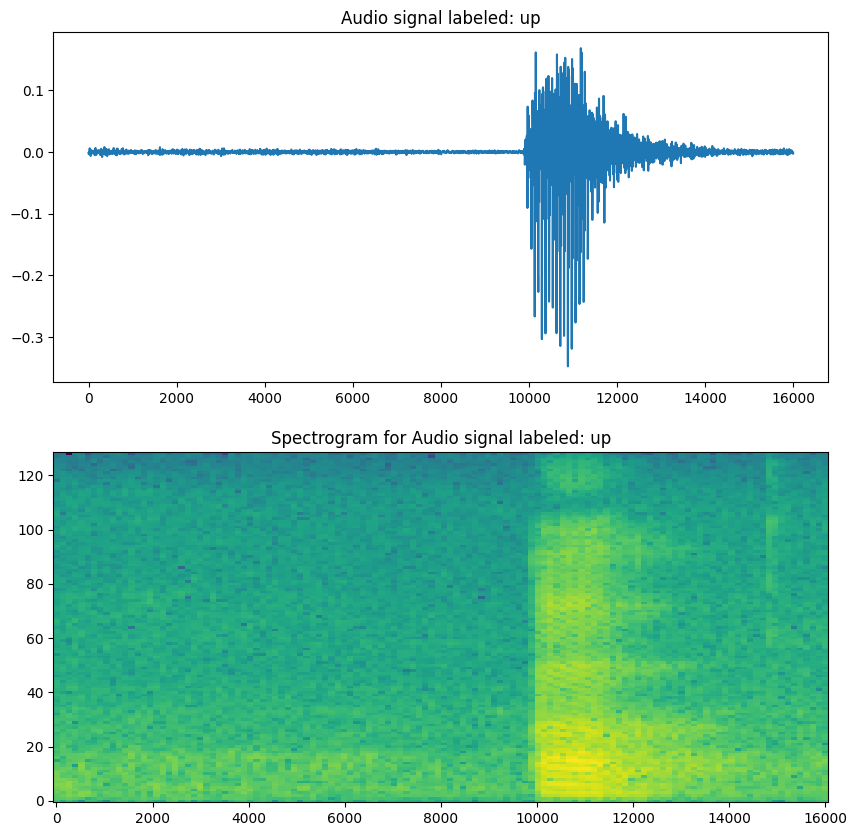

In [42]:
plot_spec(3)

#### Creating spectrogram dataset

In [52]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),   #maping get_spectrogram function to audio samples
      num_parallel_calls=tf.data.AUTOTUNE)

In [53]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)

In [57]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

In [58]:
example_spectrograms.shape

TensorShape([64, 124, 129, 1])

In [61]:
example_spectrograms.shape[1:]   #input shape

TensorShape([124, 129, 1])

In [59]:
example_spect_labels.shape

TensorShape([64])

###caching shuffling and prefetching

In [60]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

### Building Model

Model keyploint:
* tf.keras.layers.Resizing: to downsample the input to enable the model to train faster.
* tf.keras.layers.Normalization: to normalize each pixel in the image based on its mean and standard deviation.
* For the Normalization layer, its adapt method would first need to be called on the training data in order to compute aggregate statistics (that is, the mean and the standard deviation).

In [62]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()

# Fit the state of the layer to the spectrograms with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           

### Compiling the model

In [63]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

### Training the model for 10 epochs

In [64]:
EPOCHS = 10
hist = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
100/100 [==============================] - 22s 210ms/step - loss: 1.7662 - accuracy: 0.3638 - val_loss: 1.3330 - val_accuracy: 0.5713
Epoch 2/10
100/100 [==============================] - 17s 167ms/step - loss: 1.2016 - accuracy: 0.5755 - val_loss: 0.9534 - val_accuracy: 0.6844
Epoch 3/10
100/100 [==============================] - 17s 170ms/step - loss: 0.8850 - accuracy: 0.6862 - val_loss: 0.7750 - val_accuracy: 0.7337
Epoch 4/10
100/100 [==============================] - 17s 168ms/step - loss: 0.7279 - accuracy: 0.7453 - val_loss: 0.6598 - val_accuracy: 0.7862
Epoch 5/10
100/100 [==============================] - 17s 173ms/step - loss: 0.6124 - accuracy: 0.7814 - val_loss: 0.6008 - val_accuracy: 0.7906
Epoch 6/10
100/100 [==============================] - 19s 193ms/step - loss: 0.5374 - accuracy: 0.8097 - val_loss: 0.5537 - val_accuracy: 0.8263
Epoch 7/10
100/100 [==============================] - 17s 167ms/step - loss: 0.4741 - accuracy: 0.8330 - val_loss: 0.5412 - val_ac

Text(0, 0.5, 'Accuracy [%]')

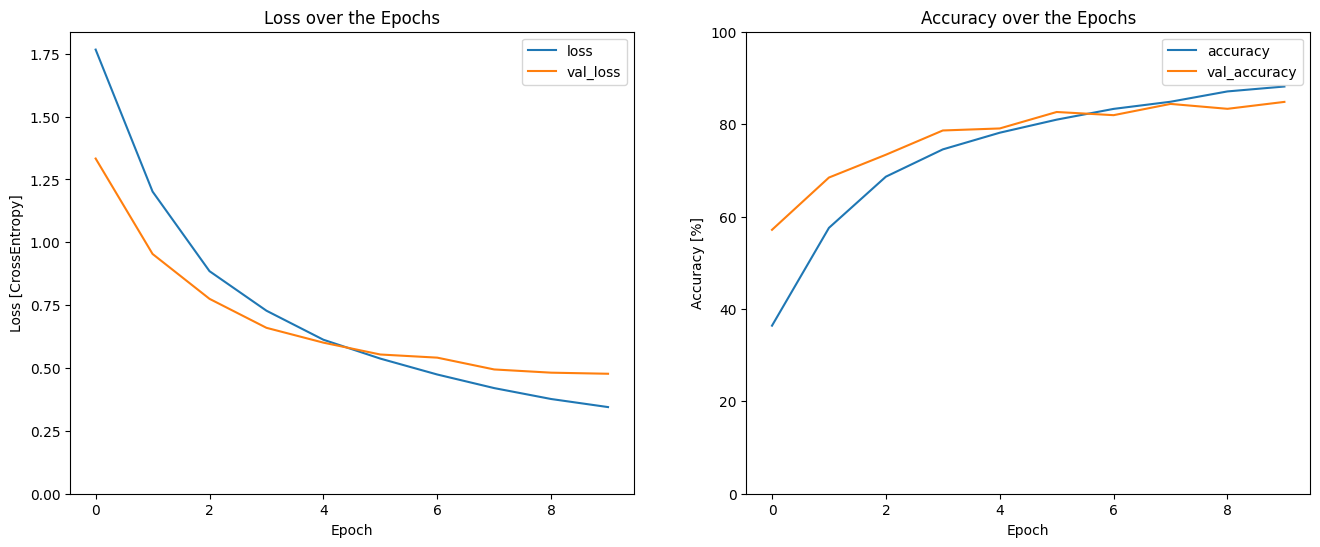

In [67]:
metrics = hist.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(hist.epoch, metrics['loss'], metrics['val_loss'])
plt.title('Loss over the Epochs')
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(hist.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.title('Accuracy over the Epochs')
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

#### Evaluating the model

In [69]:
model.evaluate(val_spectrogram_ds, return_dict=True)

25/25 [==============================] - 1s 51ms/step - loss: 0.4771 - accuracy: 0.8481


{'loss': 0.47709396481513977, 'accuracy': 0.8481249809265137}

#### Confusion Matrix

In [95]:
y_pred = model.predict(val_spectrogram_ds)

25/25 [==============================] - 1s 40ms/step


In [96]:
y_pred = tf.argmax(y_pred, axis=1)

In [97]:
y_true = tf.concat(list(val_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

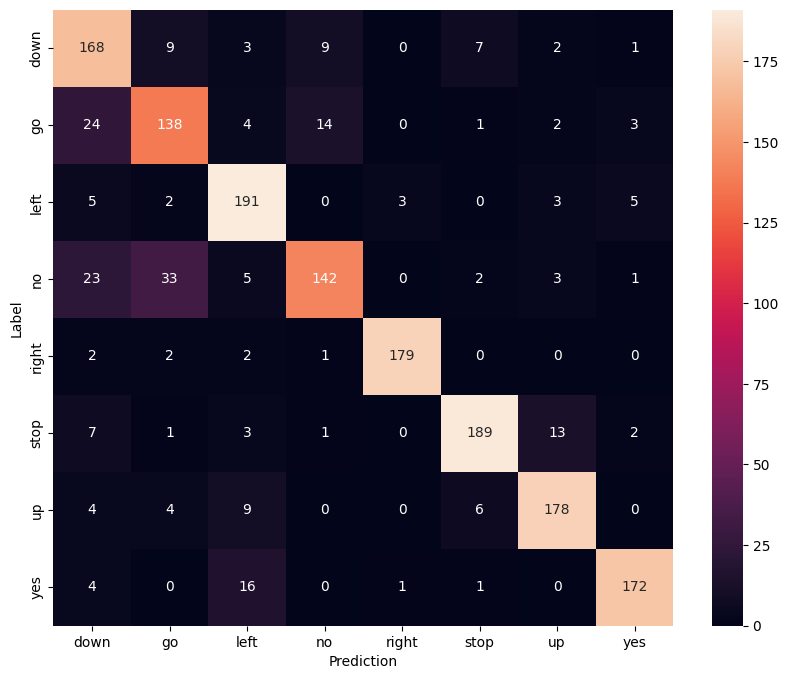

In [98]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()